In [833]:
import numpy as np
import networkx as nx
from numpy.linalg import norm ,inv,eigh
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.preprocessing import normalize
plt.rcParams['text.usetex'] = True

In [834]:
def read_points(filename):

	points = []

	with open("data/" + filename, 'r') as dataset:

		for line in dataset:
			point = [int(x) for x in line.split(',')[:2]]

			points.append(np.array(point))
	return np.array(points)

In [835]:
def build_A(points,sigma_sq=1):

	n = len(points)
	A = np.zeros((n,n))

	for i in range(n):
		si = points[i]
		for j in range(n):

			if i <= j: continue

			sj = points[j]

			#dist = norm(si-sj)**2
			A[i][j] = A[j][i] = 1#dist #np.exp(-dist/(2*(sigma_sq)))

	#A = np.exp(-A/(2*sigma_sq))
	return A

In [836]:
def build_L(A,D):

	sqrt_D = inv(sqrtm(D))

	return sqrt_D.dot(A).dot(sqrt_D)

In [837]:
def sort_vec(vector):
	return np.sqrt(sum(x * x for x in vector))

In [838]:
def compute_eigenvec(L):
	return eigh(L)

In [839]:
def sort_eigenvec(eig_vec):
	return sorted(eig_vec, key=sort_vec, reverse=True)

In [840]:
def build_X(k, sorted_eigenvec):
	k_largest_eig_vec = sorted_eigenvec[:k]
	return np.vstack(k_largest_eig_vec).T

In [841]:
def normalize_X(X):
	norm = np.linalg.norm(X)
	return X / norm

In [842]:
	dataset_file = "example1.dat"
	K = 4

	# Read points from the dataset file

	points = read_points(dataset_file)

In [843]:
points

array([[  1,   2],
       [  1,   3],
       [  1,   4],
       ...,
       [216, 235],
       [213, 235],
       [241, 235]])

In [844]:
G = nx.Graph() # Create Graph Object
G.add_edges_from(points) # Add edges from file content
A = nx.adjacency_matrix(G).toarray() # Get Adjacency matrix in dense format

In [845]:
def build_D(A):

	n = len(A)

	D = [np.sum(A[i]) for i in range(n)]

	return np.diag(D)
D = build_D(A)
print(D)

[[7 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 9 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]


In [846]:
L = build_L(A,D)
#L = nx.normalized_laplacian_matrix(G)

#A = np.asarray(nx.adjacency_matrix(G).todense())
#D=np.diag(np.sum(A, axis=1))

#D_inv = np.linalg.inv(np.sqrt(D))
#L = np.dot(np.dot(D_inv, A), D_inv)
#print(L)

In [847]:
# Get the eigenvalues and vectors sorted (it's sorted in descending order)
eigvals,eigvects = eigh(L)

#print(eigvals)
#print(eigvects)
i = 0
for x,y in zip(eigvals,eigvects):
    if i == 239:
        print(f"{x} -> {i} -> {y}")
    i += 1
eigvects[239].shape

0.9999999999999999 -> 239 -> [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.32124589e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.07998805e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.59180970e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.08581622e-01  0.00000000e+00 -1.01063867e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.09924259e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.81266551e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.33877545e-01  0.00000000e+00  0.00000000e

(241,)

In [848]:
# Stack the K largest eigenvectors
X = eigvects[:,-K:]
print(X.shape)


(241, 4)


In [849]:
# Y is the row-normalized version of X
Y = X/norm(X, axis = 0, keepdims = True)

print(np.sum( Y**2, axis=0 )) # Check that the normalization is correct

[1. 1. 1. 1.]


## K-means clustering

In [850]:
# Run KMeans algorithm
labels = KMeans(n_clusters= K).fit_predict(Y)

print(f"Labels:")
for clust in np.unique(labels):
    print(f"Cluster {clust} has  {len(np.where(labels == clust)[0])} nodes")

Labels:
Cluster 0 has  48 nodes
Cluster 1 has  117 nodes
Cluster 2 has  41 nodes
Cluster 3 has  35 nodes


C:\Users\Mauro Pungo\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


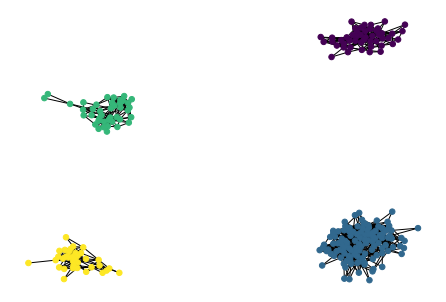

In [851]:
nx.draw(G, node_size=30,node_color = labels)

plt.savefig(f"results/{dataset_file[:-4]}_clusters")

## Graph Spectrum

241


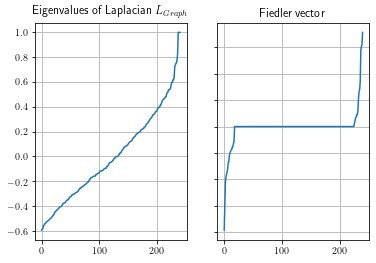

In [852]:
num_nodes = X.shape[0]
print(num_nodes)

# Eigenvector associated to the 2nd largest eigenvalue
v2 = eigvects[num_nodes - 2]
fiedler_vect = sorted(v2)

fig, axs = plt.subplots(ncols = 2,sharex = True,sharey = False)
axs[0].plot(sorted(eigvals))
axs[0].set_title('Eigenvalues of Laplacian $L_{Graph}$')
axs[1].plot(fiedler_vect)
axs[1].set_title('Fiedler vector ')
axs[0].grid()
axs[1].grid()
plt.savefig(f"results/{dataset_file[:-4]}_spectrum.png")



# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig("")
plt.show()


## Sparsity Matrix

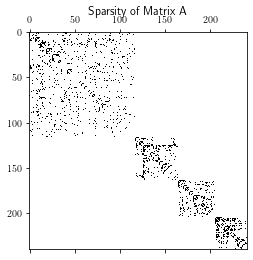

In [853]:
plt.title("Sparsity of Matrix A")

plt.spy(A)
plt.savefig(f"results/{dataset_file[:-4]}_sparsity.png")
plt.show()
